In [20]:
import mlflow
from mlflow.tracking.client import MlflowClient

from rich import print
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import ray
import os
import matplotlib.pyplot as plt

from ddistexps.utils import format_vertical_headers
import sys
sys.path.append(os.path.abspath("./utils.py")) 

from ccutils.utils import get_all_runs, get_pareto_frontier
from ccutils.inference import cluster_runs, summarize_ensembled_predictions 
from ccutils.plot import plot_ensemble_pareto_movement

%load_ext autoreload
%autoreload 2
# sns.set_theme(style="whitegrid")  
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
ray.init(namespace='DataFlow', ignore_reinit_error=True)

2024-05-06 23:54:30,202	INFO worker.py:1432 -- Using address localhost:4004 set in the environment variable RAY_ADDRESS
2024-05-06 23:54:30,203	INFO worker.py:1567 -- Connecting to existing Ray cluster at address: 104.171.203.248:4004...
2024-05-06 23:54:30,219	INFO worker.py:1585 -- Calling ray.init() again after it has already been called.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.10.13', ray_version='2.10.0', ray_commit='09abba26b5bf2707639bb637c208d062a47b46f6')

# Cascade Pareto Set

We now show the cascade pareto set with some fixed thresholds. The thresholds
can be further tuned, which we don't do here.

We will follow a similar algorithm to ensemble construction for cascades as well. To
pick a model at each cascade level,
1. Pick a $k$, the number of ensembles to create on the pareto front.
2. Divide (min-acc, max-acc) into $k$ roughly equal internvals that include the two end-points. Pick the models on the pareto frontier closest in accuracy
to these points and pick their (flops, acc) values as cluster centers.

In [21]:
# Define the relevant experiments here; Dataset -> [Experiment names]
EXPERIMENTS = {
    'CIFAR10': {
        'expnames': ['baseline/cifar10-small', 'baseline/cifar10-large',
        'distillation/cifar10-small'],
        'ds_kwargs': {'ds_name': 'CIFAR10Eval'},
        'worker_resource_req': {'num_gpus': 0.33},
    },
    #'CIFAR100': ['baseline/cifar100-small', 'baseline/cifar100-large', 'distillation/cifar100-small'],
    'ImageNet1k': {
        'expnames': ['baseline/imagenet-small', 'baseline/imagenet-sanity'],
        'ds_kwargs': {'ds_name': 'ImageNet1kEval'},
        'worker_resource_req': {'num_gpus': 0.33},
    },
    'TinyImageNet': [],
}

In [25]:
ds_names = ['CIFAR10', 'ImageNet1k']
results_buffer = {}
for ds_name in ds_names:
    print(ds_name)
    all_runs = get_all_runs(EXPERIMENTS[ds_name]['expnames'])
    # adds cluster-id, is-pareto
    all_runs = cluster_runs(all_runs, 5)
    pareto_runs = get_pareto_frontier(all_runs)
    ensemble_df = summarize_ensembled_predictions(all_runs, EXPERIMENTS)
    cascade_df = summarize_cascaded_predictions(all_runs, EXPERIMENTS)
    # Get the best model for each cluster from the pareto frontier
    results_buffer[ds_name] = {'all_runs': all_runs, 'pareto_runs':
                               pareto_runs, 'cascade_df':
                               cascade_df, 'ensemble_df': ensemble_df}

CIFAR10

num-runs: 271
metrics.val_acc_best      0
metrics.artifact_flops    0
dtype: int64
Waiting for inference (map).


 0:   0%|          | 0/14 [00:00<?, ?it/s]

Waiting for ensemble computation (reduce)


 0:   0%|          | 0/5 [00:00<?, ?it/s]

Waiting for inference (map).


 0:   0%|          | 0/5 [00:00<?, ?it/s]

ImageNet1k

num-runs: 154
metrics.val_acc_best      5
metrics.artifact_flops    0
dtype: int64
Waiting for inference (map).


 0:   0%|          | 0/15 [00:00<?, ?it/s]

Waiting for ensemble computation (reduce)


 0:   0%|          | 0/5 [00:00<?, ?it/s]

Waiting for inference (map).


 0:   0%|          | 0/5 [00:00<?, ?it/s]

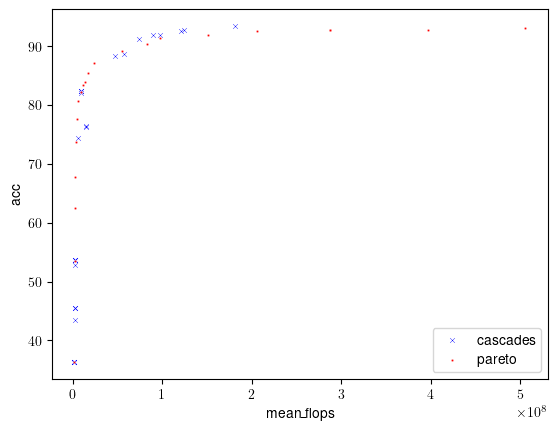

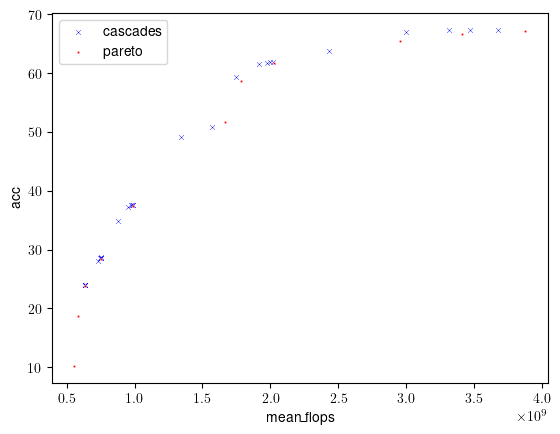

In [44]:
from ccutils.plot import plot_pareto_curve


for ds_name, data in results_buffer.items():
    all_runs, pareto_runs = data['all_runs'], data['pareto_runs']
    ensemble_df = data['ensemble_df']
    cascade_df = data['cascade_df']
    # cascade_df = cascade_df[cascade_df['n_levels'] <= 2].copy()
    #display(cascade_df)
    #plot_pareto_curve(ds_name, all_runs)
    # fig, ax = plot_ensemble_pareto_movement(ds_name, all_runs, pareto_runs,
    #                                         ensemble_df, figsize=(3.2, 1.8),
    #                                         markersize=6)
    #cascade_df['log_mean_flops'] = np.log10(cascade_df['mean_flops'])
    sns.scatterplot(data=cascade_df, x='mean_flops', y='acc', color='blue',
                    label='cascades', s=12, marker='x')
    sns.scatterplot(data=pareto_runs, x='metrics.artifact_flops',
                    y='metrics.val_acc_best', color='red', label='pareto',
                    s=12, marker='.')
    plt.show()
    # fig.savefig(f"../imgs/cascade-pareto-flops-acc-{ds_name}.pdf", bbox_inches='tight')

We need a real majority of the samples to be handled at a lower level for the
savings to be meaningful. Even then its unclear if we can beat the pareto
optimal.

Some numbers below for 100 samples, and a specified flops for models to get a 
sense of what distributiosn of deferrals lead to what level of savings.

- We need about 50% of the samples to be predicted at level-0 without loosing on the validation accuracy. That is, assuming calibration, at least 50% of the samples should be above threshold = validation accuracy. However, clearly this is not
true and thus we can at most expect an order of magnitude savings (which gets squashed under log).
- For ensembling to work, it needs to be able to push the distribution of
  deferrals while allowing changing the flops by constnat. If some form or
  deferral rule is able to increase the deferral rate for constant factor of additional flops we are in business.

In [52]:
flops = [10, 100, 1000, 10000]
dists = np.array([
    [90, 5, 3, 2],
    [80, 15, 3, 2],
    [70, 20, 7, 3],
    [50, 34, 12, 4],
    [30, 46, 18, 6],
    [10, 20, 30, 40],
])
print(np.sum(dists, axis=1))
mean_flops = (dists @ flops) / 100
mean_flops

[100 100 100 100 100 100]

array([ 244.,  253.,  397.,  559.,  829., 4321.])